# Simple chat interface to search multiple documents

***Highlight***
- Supports OpenAI and local language model. For OpenAI, you can either set OS environment OpenAI key or allow user to enter their OpenAI key. If users don't have an OpenAI key, they can always select local LLM to proceed. 
- Multiple documents are loaded to ChromaDB in a different notebook. Load multiple documents by running loaddb.ipynb 
- This notebook uses Panel to show the chat interface.

## Import libraries


In [1]:
#use GPT4All to load local LLM
from gpt4all import GPT4All 

In [2]:
#Load langchain libaries

from langchain.vectorstores import Chroma
from langchain.chains import RetrievalQA
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.llms import OpenAI

In [3]:
#Load Panel
import panel as pn
pn.extension()

import os

In [4]:
# Global Values
USER = "AI Assistant"
TTL = 1800  # 30 minutes
openai_api_key = os.environ.get("OPENAI_API_KEY")

In [5]:
# Define the widgets
text_input = pn.widgets.TextInput(placeholder="enter your message")

select_lang = pn.widgets.Select(name='Select LLM', options={'OS Env OpenAI':1, 'Enter OpenAI':2, 'Local LLM':3,}, value=3)
openai_key_input = pn.widgets.PasswordInput(name='API Key', placeholder='Enter your OpenAI API key here...')

In [14]:
# Load local ChromaDB
persist_directory = './db'
embeddings = HuggingFaceEmbeddings()
vectordb = Chroma(persist_directory=persist_directory,
                  embedding_function=embeddings)

## Make a retriever

In [7]:
# create the chain to answer questions
retriever = vectordb.as_retriever(search_kwargs={"k": 2})
model = GPT4All("gpt4all-falcon-q4_0.gguf")
prompt_template = 'USER: {0}\nASSISTANT: '

100%|█████████████████████████████████████| 4.21G/4.21G [01:50<00:00, 38.2MiB/s]


In [8]:
## Cite sources
def process_llm_response(llm_response):
    for source in llm_response["source_documents"]:
        print(f"{source.metadata['source']}, page: {source.metadata['page']+1}")

In [9]:
def format_source(source):
    chunks = []
    for chunk in source[::-1]:
        name = f"./{chunk.metadata['source']}, page: {chunk.metadata['page']+1}"
        content = chunk.page_content
        chunks.insert(0, (name, content))
    return chunks

In [18]:
@pn.cache(ttl=TTL)
def _qa_pdf(query):
    global openai_api_key
    global openai_key_input
    global select_lang
        
    if openai_key_input.value and select_lang.value == 2:
        openai_api_key = str (openai_key_input.value)  
        
    if openai_api_key:
        qa_chain = RetrievalQA.from_chain_type(llm=OpenAI(openai_api_key=openai_api_key),
                              chain_type="stuff",
                              retriever=retriever,
                              return_source_documents=True)

        response = qa_chain(query)
    else:
        response = {'query':"", 
                    'result': "", 
                    'source_documents': []}
        import time

        start = time.time()
        docs = retriever.get_relevant_documents(query)
        end = time.time()

        print (f"ChromaDB Retrieval Time: {end-start} seconds")

        system_template = str(docs)
        with model.chat_session(system_template, prompt_template):
            result = model.generate(query, temp=0)

        response['query'] = query
        response['result'] = result
        response['source_documents'] = docs

    return response

In [16]:
async def respond(query, user, chat_interface):

    if select_lang.value == 1 and not openai_api_key:
        message = "Error: Can't locate your OpenAI API key in your OS environment. Please select a different LLM."
        chat_interface.send({"user": "System", "object": message}, respond=False)
        return
    if select_lang.value == 2 and not openai_key_input.value:
        message = "Error: Missing OpenAI key in the entry field. If you don't have an OpenAI API key, use local LLM to proceed."
        chat_interface.send({"user": "System", "object": message}, respond=False)
        return    
        
    finding = pn.indicators.LoadingSpinner(value=True, size=20, name='Preparing your answer...')
    yield {"user": "Assistant", "object": finding}

    response = _qa_pdf(query)
    
    documents = format_source(response["source_documents"])
    pages_layout = pn.Accordion(*documents, sizing_mode="stretch_width", max_width=800)

    answers = pn.Column(response["result"], 
                    pn.Spacer(styles=dict(background='grey'), width=800, height=5),
                    pages_layout, 
                    )    
    finding = pn.indicators.LoadingSpinner(value=False, size=20, name='Preparing your answer...')
    yield {"user": USER, "object": finding}
    
    yield {"user": USER, "object": answers}



In [12]:
chat_interface = pn.chat.ChatInterface(
    callback=respond,
    sizing_mode="stretch_width",
    widgets=[text_input],
    disabled=False,
)

BootstrapTemplate
    [js_area] HTML(None, height=0, margin=0, sizing_mode='fixed', width=0)
    [actions] BootstrapTemplateActions()
    [browser_info] BrowserInfo(dark_mode=False, device_pixel_ratio=2, language='en-US', timezone='America/Los_Angeles', timezone_offset=480, webdriver=False)
    [busy_indicator] LoadingSpinner(height=20, width=20)
    [main-5287840080] ChatInterface(_button_data={'send': _ChatButtonData(i...}, _input_container=Row, _input_layout=Row, _placeholder=ChatMessage, _widgets={'TextInput': TextInput(cs...}, callback=<function respond a..., show_button_name=True, sizing_mode='stretch_width', widgets=[TextInput(css_classes=['c...])
    [nav-4878757008] Select(options={'OS Env OpenAI': 1, ...}, value=3)
    [nav-4878811792] PasswordInput(name='API Key', placeholder='Enter your OpenAI A...)
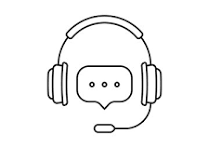

In [13]:
template = pn.template.BootstrapTemplate(
    sidebar=[
        select_lang,
        openai_key_input,
    ],
    main=[chat_interface],
    title="AI Assistant",
    logo="./image/assistant.png",
)
template.servable()